### Assignment 05 Part 2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My\ Drive/COLAB

[Errno 2] No such file or directory: 'drive/My Drive/COLAB'
/content/drive/My Drive/COLAB


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import math
import glob
import copy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

### Load Dataset usign torchvision image loader

In [0]:
data_dir = 'A_05_Part_02_Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data= datasets.ImageFolder(data_dir+'/Test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False,num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


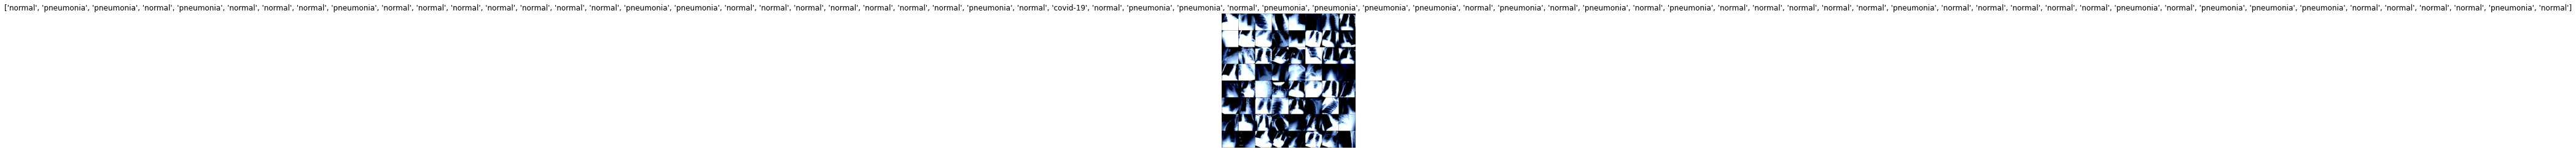

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### Task 01

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
features=[]
features.extend([nn.Linear(25088, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)

### Loss fucntion and optimizer

In [0]:
Epochs = 50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total=0
    correct = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels.float())   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
        running_loss += loss.item()
        # Accuracy calculation
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    
    tacc.append(100 * correct / total)
    tloss.append(running_loss)
    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data
            images, labels = images.to(device), labels.to(device)
            labels= torch.nn.functional.one_hot(labels, len(class_names))
            for i in range(labels[:,0].shape[0]):
              if(labels[:,0][i]==1):
                labels[:,2][i]=1
            outputs = vgg16(images)
            loss = criterion(outputs, labels.float()) 
            thresh = Variable(torch.Tensor([0.50])).to(device)
            one = Variable(torch.Tensor([1])).to(device)
            zero = Variable(torch.Tensor([0])).to(device)
            predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
            valid_loss += loss.item()
            # Accuracy calculation
            total += labels.size(0)
            correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    vacc.append(100 * correct / total)
    vloss.append(valid_loss)
        
    torch.save(vgg16.state_dict(), 'vgg16_BCEWithLogitsLoss.pth')

print('Finished Training')

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.231734: : 97it [07:26,  4.60s/it]
Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.187387: : 97it [01:55,  1.19s/it]
Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.295095: : 97it [01:54,  1.18s/it]
Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.203321: : 97it [01:56,  1.20s/it]
Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.226465: : 97it [01:55,  1.19s/it]
Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.172023: : 97it [01:59,  1.23s/it]
Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.202258: : 97it [01:59,  1.23s/it]
Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.185404: : 97it [01:58,  1.22s/it]
Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.193821: : 97it [01:56,  1.20s/it]
Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.199424: : 97it [01:55,  1.19s/it]
Train Epoch: 10 [3080/6200 (57%)]	Loss: 0.289421: : 97it [01:55,  1.19s/it]
Train Epoch: 11 [3080/6200 (57%)]	Loss: 0.246203: : 97it [01:54,  1.18s/it]
Train Epoch: 12 [3080/6200 (57%)]	Loss: 0.212165: : 97it [01:55,  1.19s/it]
Train Epoch: 13 [3080/

Finished Training


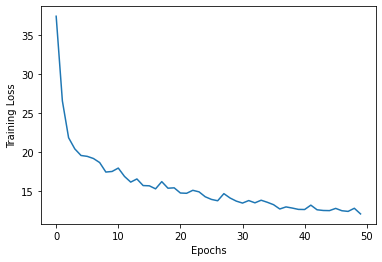

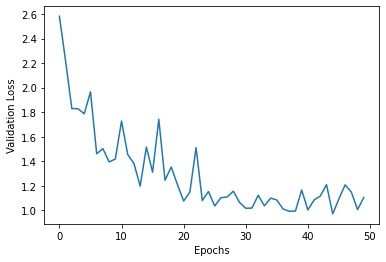

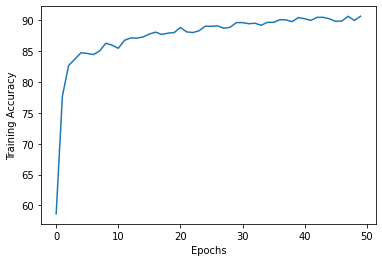

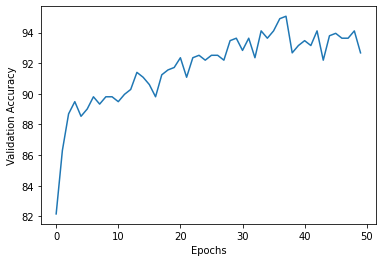

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')
  plt.show()
  plt.plot(vloss)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.show()
  plt.plot(vacc)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.show()
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


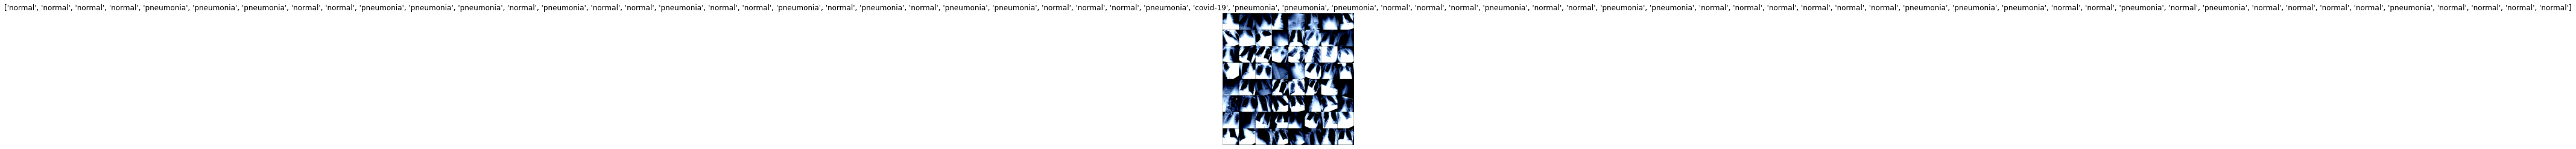

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = vgg16(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)

        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the train images: 88 %


(array([[[5994,    6],
         [  76,  124]],
 
        [[2089,  111],
         [ 349, 3651]],
 
        [[3848,  352],
         [ 167, 1833]]]), 0.9134454915920474)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


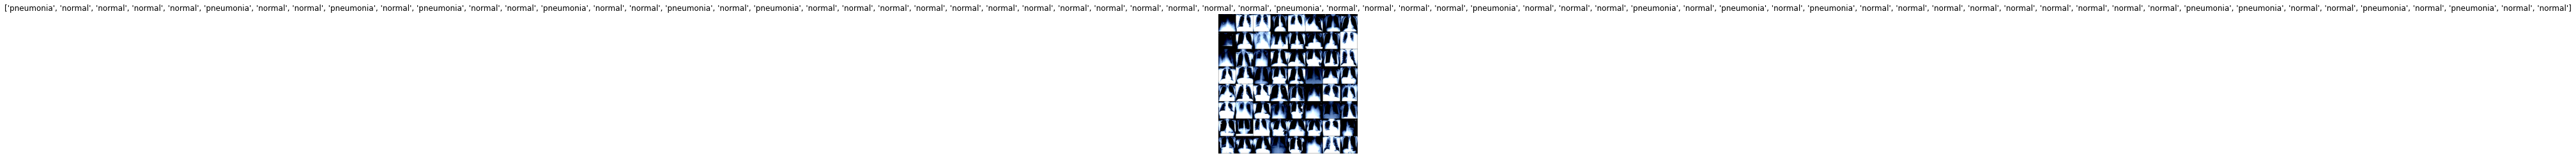

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = vgg16(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the validation images: 90 %


(array([[[599,   1],
         [  8,  20]],
 
        [[215,  13],
         [ 21, 379]],
 
        [[392,  36],
         [  9, 191]]]), 0.9291939824384978)

In [0]:
import csv

with open('vgg16BCEW.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    total=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = vgg16(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        i=total
        count=0
        while(i<total+labels.shape[0]):
          employee_writer.writerow([test_data.imgs[i][0], predicted[count][0].item(),predicted[count][2].item(),predicted[count][1].item()])
          count=count+1
          i=i+1
        total+=labels.shape[0]

### Load pre-trained ResNet18


In [0]:
# Load the pretrained model from pytorch
resnet = models.resnet18(pretrained=True)

In [0]:
features=[]
features.extend([nn.Linear(512, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])

In [0]:
resnet.fc = nn.Sequential(*features)

### Loss fucntion and optimizer

In [0]:
Epochs = 50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total=0
    correct = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)               #----> forward pass
        loss = criterion(outputs, labels.float())   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
        running_loss += loss.item()
        # Accuracy calculation
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    
    tacc.append(100 * correct / total)
    tloss.append(running_loss)
    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data
            images, labels = images.to(device), labels.to(device)
            labels= torch.nn.functional.one_hot(labels, len(class_names))
            for i in range(labels[:,0].shape[0]):
              if(labels[:,0][i]==1):
                labels[:,2][i]=1
            outputs = resnet(images)
            loss = criterion(outputs, labels.float()) 
            thresh = Variable(torch.Tensor([0.50])).to(device)
            one = Variable(torch.Tensor([1])).to(device)
            zero = Variable(torch.Tensor([0])).to(device)
            predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
            valid_loss += loss.item()
            # Accuracy calculation
            total += labels.size(0)
            correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    vacc.append(100 * correct / total)
    vloss.append(valid_loss)
        
    torch.save(resnet.state_dict(), 'resnet_BCEWithLogitsLoss.pth')

print('Finished Training')

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.414556: : 97it [06:01,  3.72s/it]
Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.245806: : 97it [02:01,  1.26s/it]
Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.244341: : 97it [02:02,  1.26s/it]
Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.190393: : 97it [02:03,  1.28s/it]
Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.179642: : 97it [02:01,  1.25s/it]
Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.219049: : 97it [02:03,  1.27s/it]
Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.157986: : 97it [02:03,  1.27s/it]
Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.156851: : 97it [02:02,  1.26s/it]
Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.283762: : 97it [02:02,  1.26s/it]
Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.141965: : 97it [02:01,  1.25s/it]
Train Epoch: 10 [3080/6200 (57%)]	Loss: 0.213697: : 97it [02:01,  1.25s/it]
Train Epoch: 11 [3080/6200 (57%)]	Loss: 0.230756: : 97it [02:02,  1.27s/it]
Train Epoch: 12 [3080/6200 (57%)]	Loss: 0.335483: : 97it [02:03,  1.27s/it]
Train Epoch: 13 [3080/

Finished Training


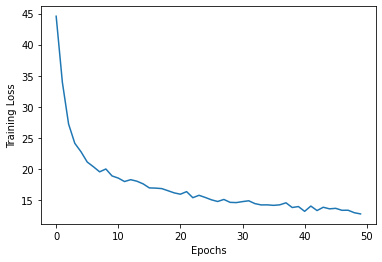

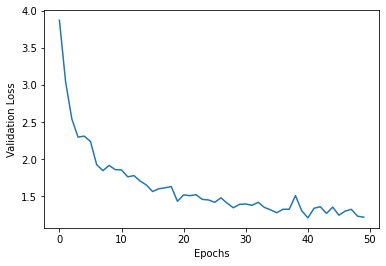

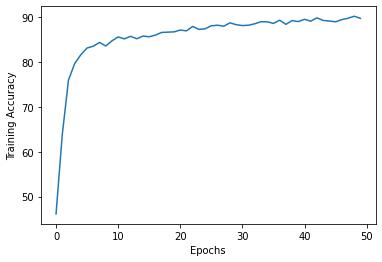

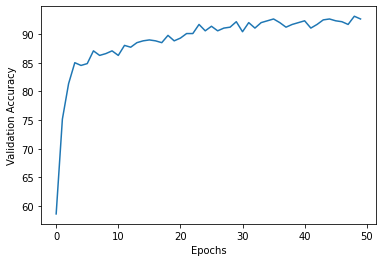

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')
  plt.show()
  plt.plot(vloss)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.show()
  plt.plot(vacc)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.show()
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


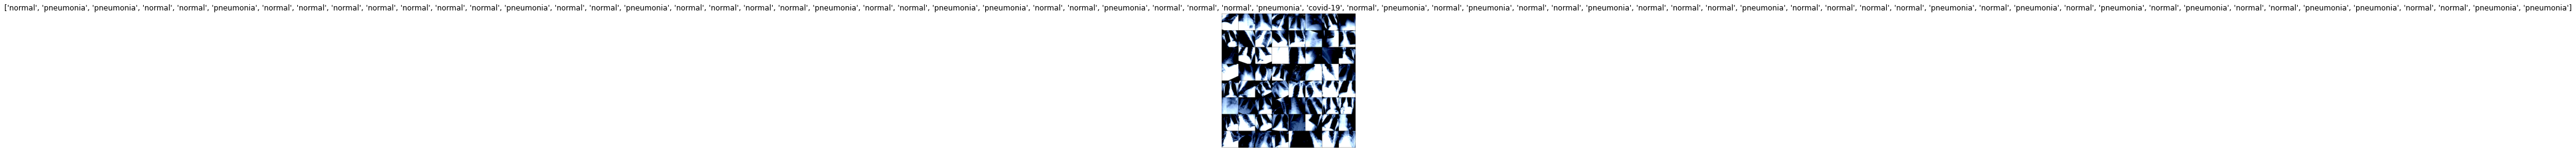

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
confuse1=np.zeros((3,3),dtype=int)
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = resnet(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)

        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the train images: 88 %


(array([[[5994,    6],
         [ 126,   74]],
 
        [[1988,  212],
         [ 215, 3785]],
 
        [[3936,  264],
         [ 304, 1696]]]), 0.9060587176757141)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


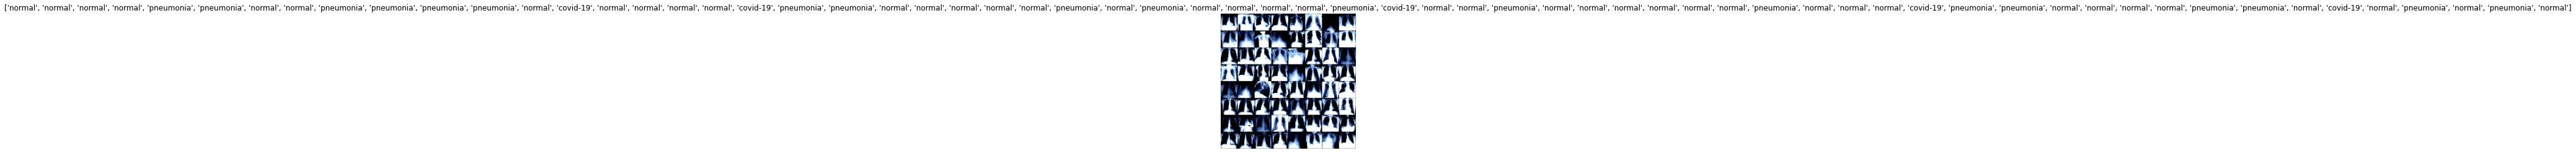

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = resnet(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)

        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the validation images: %d %%' % ( 100 * correct / total))
confuse1,f10

Accuracy of the network on the validation images: 89 %


(array([[[600,   0],
         [ 16,  12]],
 
        [[208,  20],
         [ 16, 384]],
 
        [[400,  28],
         [ 22, 178]]]), 0.8980846603571858)

In [0]:
import csv

with open('resnet18BCEW.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    total=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = resnet(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        i=total
        count=0
        while(i<total+labels.shape[0]):
          employee_writer.writerow([test_data.imgs[i][0], predicted[count][0].item(),predicted[count][2].item(),predicted[count][1].item()])
          count=count+1
          i=i+1
        total+=labels.shape[0]

### Task 02

In [0]:
criterion = nn.BCEWithLogitsLoss()

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=2, gamma=1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def Focal_loss(self, inputs, targets):
        BCE_loss=criterion(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

In [0]:
foca_loss=FocalLoss()

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
features=[]
features.extend([nn.Linear(25088, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)

### Loss fucntion and optimizer

In [0]:
Epochs = 50
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total=0
    correct = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = foca_loss.Focal_loss(outputs,labels.float())  #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
        running_loss += loss.item()
        # Accuracy calculation
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    
    tacc.append(100 * correct / total)
    tloss.append(running_loss)
    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data
            images, labels = images.to(device), labels.to(device)
            labels= torch.nn.functional.one_hot(labels, len(class_names))
            for i in range(labels[:,0].shape[0]):
              if(labels[:,0][i]==1):
                labels[:,2][i]=1
            outputs = vgg16(images)
            loss = foca_loss.Focal_loss(outputs,labels.float()) 

            thresh = Variable(torch.Tensor([0.50])).to(device)
            one = Variable(torch.Tensor([1])).to(device)
            zero = Variable(torch.Tensor([0])).to(device)
            predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
            valid_loss += loss.item()
            # Accuracy calculation
            total += labels.size(0)
            correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    vacc.append(100 * correct / total)
    vloss.append(valid_loss)
        
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')

print('Finished Training')

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.095143: : 97it [14:01,  8.67s/it]
Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.085759: : 97it [02:55,  1.81s/it]
Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.083364: : 97it [02:56,  1.81s/it]
Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.047290: : 97it [02:55,  1.81s/it]
Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.170437: : 97it [02:54,  1.80s/it]
Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.031662: : 97it [02:55,  1.80s/it]
Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.093995: : 97it [02:55,  1.81s/it]
Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.055633: : 97it [02:56,  1.82s/it]
Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.055636: : 97it [02:56,  1.82s/it]
Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.050625: : 97it [02:57,  1.83s/it]
Train Epoch: 10 [3080/6200 (57%)]	Loss: 0.086602: : 97it [02:54,  1.80s/it]
Train Epoch: 11 [3080/6200 (57%)]	Loss: 0.045128: : 97it [02:55,  1.81s/it]
Train Epoch: 12 [3080/6200 (57%)]	Loss: 0.030781: : 97it [02:56,  1.82s/it]
Train Epoch: 13 [3080/

Finished Training


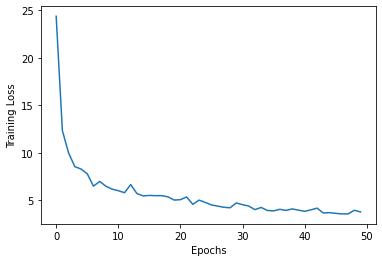

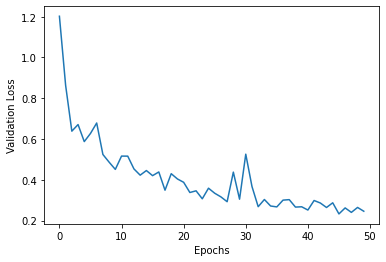

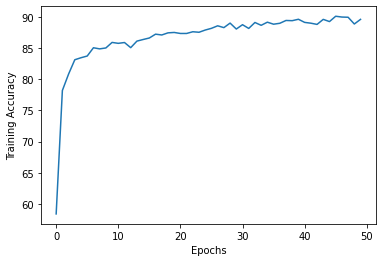

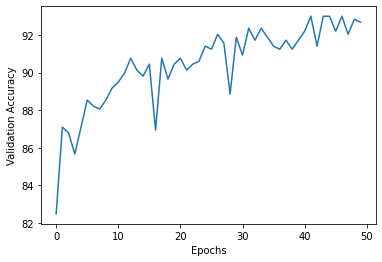

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')
  plt.show()
  plt.plot(vloss)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.show()
  plt.plot(vacc)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.show()
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


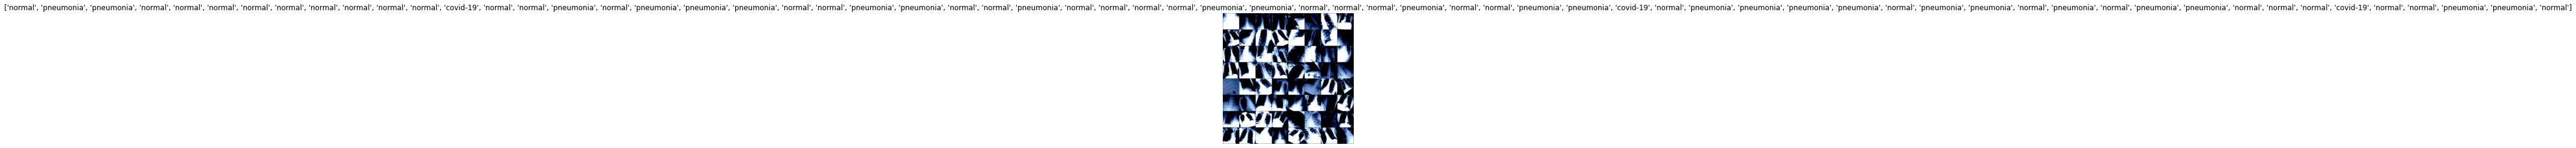

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = vgg16(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the train images: 88 %


(array([[[5992,    8],
         [  91,  109]],
 
        [[2018,  182],
         [ 247, 3753]],
 
        [[3937,  263],
         [ 271, 1729]]]), 0.9378389490720238)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


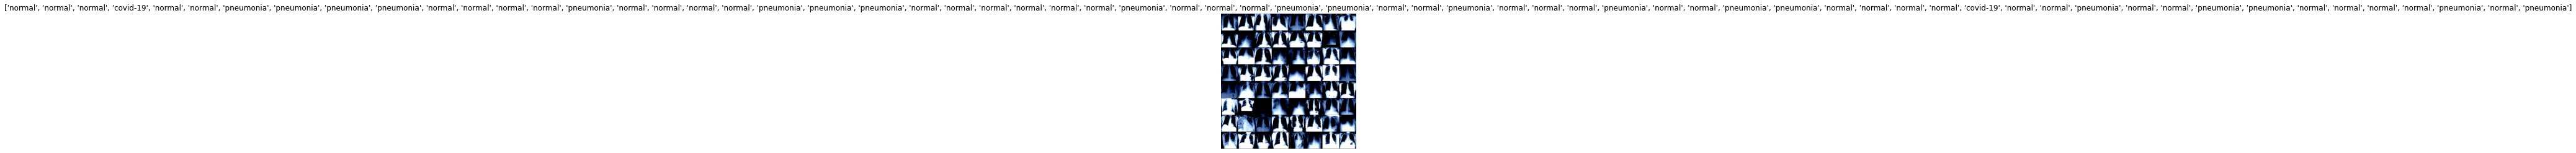

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = vgg16(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the validation images: 91 %


(array([[[598,   2],
         [ 10,  18]],
 
        [[214,  14],
         [ 13, 387]],
 
        [[407,  21],
         [ 14, 186]]]), 0.9333243129731208)

In [0]:
import csv

with open('vgg16.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    total=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = vgg16(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        i=total
        count=0
        while(i<total+labels.shape[0]):
          employee_writer.writerow([test_data.imgs[i][0], predicted[count][0].item(),predicted[count][2].item(),predicted[count][1].item()])
          count=count+1
          i=i+1
        total+=labels.shape[0]

### Load pre-trained ResNet18


In [0]:
# Load the pretrained model from pytorch
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
features=[]
features.extend([nn.Linear(512, (69*10)+100)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear((69*10)+100,len(class_names))])

In [0]:
resnet.fc = nn.Sequential(*features)

### Loss fucntion and optimizer

In [0]:
Epochs = 50
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()
tloss=[]
vloss=[]
tacc=[]
vacc=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total=0
    correct = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        for i in range(labels[:,0].shape[0]):
          if(labels[:,0][i]==1):
            labels[:,2][i]=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)               #----> forward pass
        loss = foca_loss.Focal_loss(outputs,labels.float())  #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
        running_loss += loss.item()
        # Accuracy calculation
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
    
    tacc.append(100 * correct / total)
    tloss.append(running_loss)
    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data
            images, labels = images.to(device), labels.to(device)
            labels= torch.nn.functional.one_hot(labels, len(class_names))
            for i in range(labels[:,0].shape[0]):
              if(labels[:,0][i]==1):
                labels[:,2][i]=1
            outputs = resnet(images)

            loss = foca_loss.Focal_loss(outputs,labels.float()) 

            thresh = Variable(torch.Tensor([0.50])).to(device)
            one = Variable(torch.Tensor([1])).to(device)
            zero = Variable(torch.Tensor([0])).to(device)
            predicted = torch.where(outputs > thresh, one, zero)
        # print statistics
            valid_loss += loss.item()
            # Accuracy calculation
            total += labels.size(0)
            correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
    vacc.append(100 * correct / total)
    vloss.append(valid_loss)
        
    torch.save(resnet.state_dict(), 'res18_focal_loss.pth')

print('Finished Training')

Train Epoch: 0 [3080/6200 (57%)]	Loss: 0.279288: : 97it [01:47,  1.11s/it]
Train Epoch: 1 [3080/6200 (57%)]	Loss: 0.162394: : 97it [01:47,  1.11s/it]
Train Epoch: 2 [3080/6200 (57%)]	Loss: 0.194840: : 97it [01:47,  1.11s/it]
Train Epoch: 3 [3080/6200 (57%)]	Loss: 0.058614: : 97it [01:48,  1.11s/it]
Train Epoch: 4 [3080/6200 (57%)]	Loss: 0.153758: : 97it [01:48,  1.11s/it]
Train Epoch: 5 [3080/6200 (57%)]	Loss: 0.069756: : 97it [01:47,  1.11s/it]
Train Epoch: 6 [3080/6200 (57%)]	Loss: 0.048835: : 97it [01:48,  1.12s/it]
Train Epoch: 7 [3080/6200 (57%)]	Loss: 0.071820: : 97it [01:49,  1.12s/it]
Train Epoch: 8 [3080/6200 (57%)]	Loss: 0.029571: : 97it [01:49,  1.13s/it]
Train Epoch: 9 [3080/6200 (57%)]	Loss: 0.039359: : 97it [01:49,  1.13s/it]
Train Epoch: 10 [3080/6200 (57%)]	Loss: 0.114300: : 97it [01:50,  1.13s/it]
Train Epoch: 11 [3080/6200 (57%)]	Loss: 0.096629: : 97it [01:50,  1.14s/it]
Train Epoch: 12 [3080/6200 (57%)]	Loss: 0.147168: : 97it [01:51,  1.15s/it]
Train Epoch: 13 [3080/

Finished Training


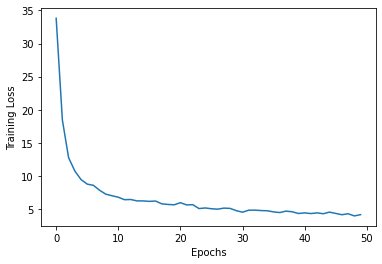

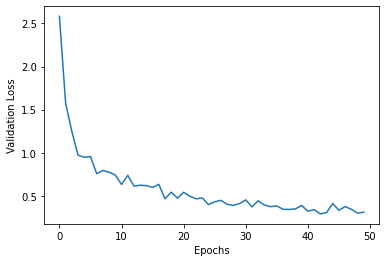

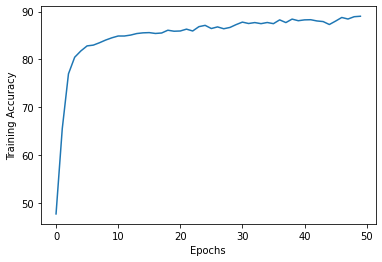

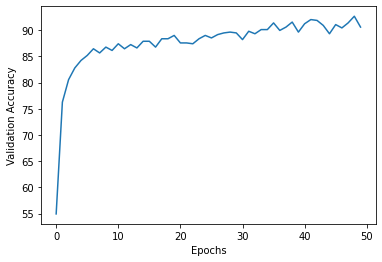

In [0]:
  plt.plot(tloss)
  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')
  plt.show()
  plt.plot(vloss)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Loss')
  plt.show()
  plt.plot(tacc)
  plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.show()
  plt.plot(vacc)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.show()
  
  #Curves

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


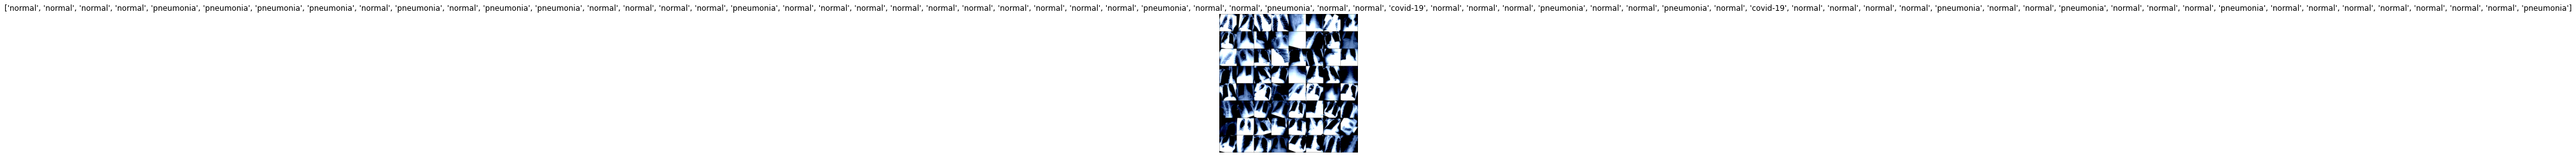

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = resnet(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the train images: 87 %


(array([[[5988,   12],
         [ 126,   74]],
 
        [[1959,  241],
         [ 243, 3757]],
 
        [[3918,  282],
         [ 332, 1668]]]), 0.8610190484476727)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


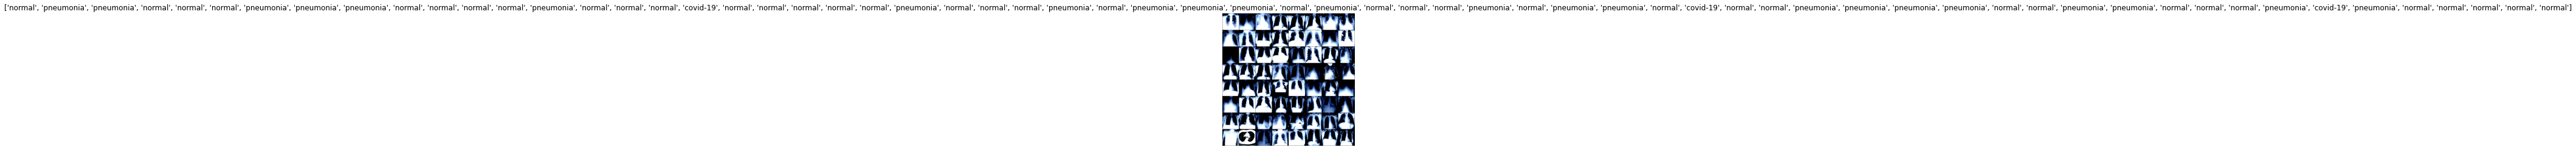

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
correct = 0
total = 0
f10=0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = resnet(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        f10=(f10+f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average="micro"))/2
        if(total==0):
          confuse1=multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        else:
          confuse1=confuse1+multilabel_confusion_matrix(labels.cpu().numpy(),predicted.cpu().numpy())
        total += labels.size(0)
        correct += torch.sum(torch.all(torch.eq(predicted, labels),dim=1)).item()
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))
confuse1,f10

Accuracy of the network on the validation images: 89 %


(array([[[599,   1],
         [ 15,  13]],
 
        [[207,  21],
         [ 16, 384]],
 
        [[399,  29],
         [ 24, 176]]]), 0.9402490656039162)

In [0]:
import csv

with open('resnet18.csv', mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    total=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels= torch.nn.functional.one_hot(labels, len(class_names))
        outputs = resnet(images)
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(outputs > thresh, one, zero)
        i=total
        count=0
        while(i<total+labels.shape[0]):
          employee_writer.writerow([test_data.imgs[i][0], predicted[count][0].item(),predicted[count][2].item(),predicted[count][1].item()])
          count=count+1
          i=i+1
        total+=labels.shape[0]